<a href="https://colab.research.google.com/github/dlmacedo/ml-dl-notebooks/blob/master/notebooks/machine-learning/SCIKIT_LEARN_05_Grid_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Efficiently searching for optimal tuning parameters

Created by [Data School](http://www.dataschool.io/). Modified by [David Macêdo](https://github.com/dlmacedo).

## Agenda

- How can K-fold cross-validation be used to search for an **optimal tuning parameter**?
- How can this process be made **more efficient**?
- How do you search for **multiple tuning parameters** at once?
- What do you do with those tuning parameters before making **real predictions**?
- How can the **computational expense** of this process be reduced?

## Review of K-fold cross-validation

Steps for cross-validation:

- Dataset is split into K "folds" of **equal size**
- Each fold acts as the **testing set** 1 time, and acts as the **training set** K-1 times
- **Average testing performance** is used as the estimate of out-of-sample performance

Benefits of cross-validation:

- More **reliable** estimate of out-of-sample performance than train/test split
- Can be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**

Drawbacks of cross-validation:

- Can be computationally **expensive**

## Review of parameter tuning using `cross_val_score`

**Goal:** Select the best tuning parameters (aka "hyperparameters") for KNN on the iris dataset

In [0]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# read in the iris data
iris = load_iris()

# create X (features) and y (response)
X = iris.data
y = iris.target

In [3]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[1.         0.93333333 1.         1.         0.86666667 0.93333333
 0.93333333 1.         1.         1.        ]


In [4]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.9666666666666668


In [5]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.96, 0.9533333333333334, 0.9666666666666666, 0.9666666666666666, 0.9666666666666668, 0.9666666666666668, 0.9666666666666668, 0.9666666666666668, 0.9733333333333334, 0.9666666666666668, 0.9666666666666668, 0.9733333333333334, 0.9800000000000001, 0.9733333333333334, 0.9733333333333334, 0.9733333333333334, 0.9733333333333334, 0.9800000000000001, 0.9733333333333334, 0.9800000000000001, 0.9666666666666666, 0.9666666666666666, 0.9733333333333334, 0.96, 0.9666666666666666, 0.96, 0.9666666666666666, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334]


Text(0, 0.5, 'Cross-Validated Accuracy')

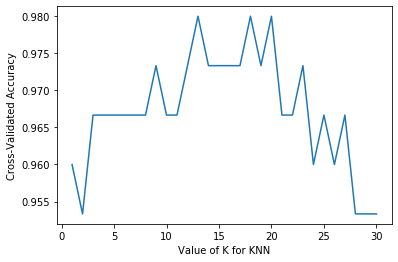

In [6]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## More efficient parameter tuning using `GridSearchCV`

Allows you to define a **grid of parameters** that will be **searched** using K-fold cross-validation

In [0]:
from sklearn.model_selection import GridSearchCV

In [8]:
# define the parameter values that should be searched
k_range = list(range(1, 31))
print(k_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [9]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


In [0]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)

- You can set **`n_jobs = -1`** to run computations in parallel (if supported by your computer and OS)

In [11]:
# fit the grid with data
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=30, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [12]:
# view the results as a pandas DataFrame
import pandas as pd
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.960000,0.053333,{'n_neighbors': 1}
1,0.953333,0.052068,{'n_neighbors': 2}
2,0.966667,0.044721,{'n_neighbors': 3}
3,0.966667,0.044721,{'n_neighbors': 4}
4,0.966667,0.044721,{'n_neighbors': 5}
5,0.966667,0.044721,{'n_neighbors': 6}
6,0.966667,0.044721,{'n_neighbors': 7}
7,0.966667,0.044721,{'n_neighbors': 8}
8,0.973333,0.032660,{'n_neighbors': 9}
9,0.966667,0.044721,{'n_neighbors': 10}


In [13]:
# examine the first result
print(grid.cv_results_['params'][0])
print(grid.cv_results_['mean_test_score'][0])

{'n_neighbors': 1}
0.96


In [14]:
# print the array of mean scores only
grid_mean_scores = grid.cv_results_['mean_test_score']
print(grid_mean_scores)

[0.96       0.95333333 0.96666667 0.96666667 0.96666667 0.96666667
 0.96666667 0.96666667 0.97333333 0.96666667 0.96666667 0.97333333
 0.98       0.97333333 0.97333333 0.97333333 0.97333333 0.98
 0.97333333 0.98       0.96666667 0.96666667 0.97333333 0.96
 0.96666667 0.96       0.96666667 0.95333333 0.95333333 0.95333333]


Text(0, 0.5, 'Cross-Validated Accuracy')

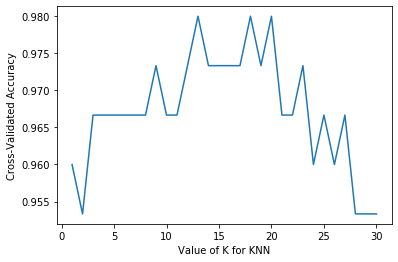

In [15]:
# plot the results
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [16]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.98
{'n_neighbors': 13}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')


## Searching multiple parameters simultaneously

- **Example:** tuning `max_depth` and `min_samples_leaf` for a `DecisionTreeClassifier`
- Could tune parameters **independently**: change `max_depth` while leaving `min_samples_leaf` at its default value, and vice versa
- But, best performance might be achieved when **neither parameter** is at its default value

In [0]:
# define the parameter values that should be searched
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']

In [18]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [19]:
# instantiate and fit the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=30, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [20]:
# view the results
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.960000,0.053333,"{'n_neighbors': 1, 'weights': 'uniform'}"
1,0.960000,0.053333,"{'n_neighbors': 1, 'weights': 'distance'}"
2,0.953333,0.052068,"{'n_neighbors': 2, 'weights': 'uniform'}"
3,0.960000,0.053333,"{'n_neighbors': 2, 'weights': 'distance'}"
4,0.966667,0.044721,"{'n_neighbors': 3, 'weights': 'uniform'}"
5,0.966667,0.044721,"{'n_neighbors': 3, 'weights': 'distance'}"
6,0.966667,0.044721,"{'n_neighbors': 4, 'weights': 'uniform'}"
7,0.966667,0.044721,"{'n_neighbors': 4, 'weights': 'distance'}"
8,0.966667,0.044721,"{'n_neighbors': 5, 'weights': 'uniform'}"
9,0.966667,0.044721,"{'n_neighbors': 5, 'weights': 'distance'}"


In [21]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.98
{'n_neighbors': 13, 'weights': 'uniform'}


## Using the best parameters to make predictions

In [22]:
# train your model using all data and the best known parameters
knn = KNeighborsClassifier(n_neighbors=13, weights='uniform')
knn.fit(X, y)

# make a prediction on out-of-sample data
knn.predict([[3, 5, 4, 2]])

array([1])

In [23]:
# shortcut: GridSearchCV automatically refits the best model using all of the data
grid.predict([[3, 5, 4, 2]])

array([1])

## Reducing computational expense using `RandomizedSearchCV`

- Searching many different parameters at once may be computationally infeasible
- `RandomizedSearchCV` searches a subset of the parameters, and you control the computational "budget"

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
# specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options)

- **Important:** Specify a continuous distribution (rather than a list of values) for any continous parameters

In [26]:
# n_iter controls the number of searches
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5, return_train_score=False)
rand.fit(X, y)
pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.973333,0.032660,"{'weights': 'distance', 'n_neighbors': 16}"
1,0.966667,0.033333,"{'weights': 'uniform', 'n_neighbors': 22}"
2,0.980000,0.030551,"{'weights': 'uniform', 'n_neighbors': 18}"
3,0.966667,0.044721,"{'weights': 'uniform', 'n_neighbors': 27}"
4,0.953333,0.042687,"{'weights': 'uniform', 'n_neighbors': 29}"
5,0.973333,0.032660,"{'weights': 'distance', 'n_neighbors': 10}"
6,0.966667,0.044721,"{'weights': 'distance', 'n_neighbors': 22}"
7,0.973333,0.044222,"{'weights': 'uniform', 'n_neighbors': 14}"
8,0.973333,0.044222,"{'weights': 'distance', 'n_neighbors': 12}"
9,0.973333,0.032660,"{'weights': 'uniform', 'n_neighbors': 15}"


In [27]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.98
{'weights': 'uniform', 'n_neighbors': 18}


In [28]:
# run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
best_scores = []
for _ in range(20):
    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, return_train_score=False)
    rand.fit(X, y)
    best_scores.append(round(rand.best_score_, 3))
print(best_scores)

[0.98, 0.98, 0.973, 0.973, 0.98, 0.98, 0.973, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98]


## Resources

- scikit-learn documentation: [Grid search](http://scikit-learn.org/stable/modules/grid_search.html), [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
- Timed example: [Comparing randomized search and grid search](http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html)
- scikit-learn workshop by Andreas Mueller: [Video segment on randomized search](https://youtu.be/0wUF_Ov8b0A?t=17m38s) (3 minutes), [related notebook](https://github.com/amueller/pydata-nyc-advanced-sklearn/blob/master/Chapter%203%20-%20Randomized%20Hyper%20Parameter%20Search.ipynb)
- Paper by Yoshua Bengio: [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)